# S3. Score Consistency

Here, we briefly demonstrate the similarities and discrepancies in the pipeline outputs.

In [1]:
import os
import functools

import pandas as pd
import scipy

import scanpy as sc

import cell2cell as c2c
from liana.method.sc._rank_aggregate import AggregateClass, _rank_aggregate_meta
from liana.method.sc import cellphonedb, natmi, singlecellsignalr

data_path = '../../data/'
output_folder = os.path.join(data_path, 'liana-outputs/')
c2c.io.directories.create_directory(output_folder)

../../data/liana-outputs/ already exists.


## S3-A1. Comparison with R output:

There are minor differences with the LIANA implementation in R that lead to outputs not being identical

- SingleCellSignalR Magnitude (lrscore): precision - slightly different after 3rd decimal place
- LogFC Specificity (lr_logfc): similar relative differences but different exact values
- CellPhoneDB Specificity (cellphone_pvals): similar relative differences but different exact values
- CellChat: not run by default in R

Let's check the consistency in the magnitude aggregate rank score when running the different methods that report magnitude (excluding CellChat, which is not present by default in R). 

In [2]:
adata = sc.read_h5ad(os.path.join(data_path, 'processed.h5ad'))
sadata = adata[adata.obs['sample']=='C100']

In [3]:
# make rank_aggregate function that only runs on methods of choice and only for Magnitude
rank_aggregate_partial = AggregateClass(_rank_aggregate_meta, methods=[cellphonedb, natmi, singlecellsignalr])
rank_aggregate_partial(adata = sadata, 
                       groupby='celltype', 
                       use_raw = False, # run on log- and library-normalized counts
                       verbose = True, 
                       inplace = True
                      )

Using `.X`!
/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
5580 features of mat are empty, they will be removed.
/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/pandas/core/indexing.py:1819: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:142: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The following cell identities were excluded: Plasma
Using resource `consensus`.
0.33 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 2548 samples and 19218 features
Running CellPhoneDB


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 249.89it/s]


Running NATMI
Running SingleCellSignalR


/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/liana/method/sc/_rank_aggregate.py:144: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


In [4]:
rel_cols = ['source', 'target', 'ligand_complex', 'receptor_complex', 'magnitude_rank']
liana_aggregate_partial = sadata.uns['liana_res'].loc[:,rel_cols]
liana_aggregate_partial.sort_values(by = ['source', 'target', 'ligand_complex', 'receptor_complex'], inplace = True)
liana_aggregate_partial.to_csv(os.path.join(output_folder, 'magnitude_ranks_python.csv'))
liana_aggregate_partial.head()

,source,target,ligand_complex,receptor_complex,magnitude_rank
67,B,B,ACTR2,ADRB2,0.405892
17,B,B,ADAM17,ITGB1,0.081878
54,B,B,ADAM17,RHBDF2,0.334024
23,B,B,ADAM28,ITGA4,0.403503
8,B,B,APOC2,LRP1,1.000000


Note, to run the correlation, make sure to have run the [companion Python tutorial](../ccc_R/S3_Score_Consistency.ipynb) up to the point where you save the csv named "magnitude_ranks_R.csv". 

In [5]:
# read and format R aggregate rank
lap_R = pd.read_csv(os.path.join(output_folder, 'magnitude_ranks_R.csv'), index_col = 0)
lap_R.columns = ['source', 'target', 'ligand_complex', 'receptor_complex', 'aggregate_rank']

# merge the two scores
la = pd.merge(liana_aggregate_partial, lap_R, on = ['source', 'target', 'ligand_complex', 'receptor_complex'], 
                                                how = 'inner')
sr = scipy.stats.spearmanr(la.magnitude_rank, la.aggregate_rank).statistic
print('The spearman correlation bewteen R and python aggregate magnitude scores is: {:.2f}'.format(sr))

The spearman correlation bewteen R and python aggregate magnitude scores is: 0.98


## S3-A2. Sensitivity of Consensus to Scoring Methods

We can check the extent to which the consensus score is influenced by individual scoring method types. To do so, we can re-run the scoring pipeline on one sample (sample C100) as in [Tutorial 02](./02-Infer-Communication-Scores.ipynb), but see how the consensus score changes as we exclude each of one scoring method type. 

In [6]:
from functools import reduce

import matplotlib

import liana
from liana.method import cellphonedb, connectome, logfc, natmi, singlecellsignalr, cellchat
from liana.method.sc._rank_aggregate import AggregateClass, _rank_aggregate_meta as aggregate_meta

First, let's load the sample data from Tutorial 02:

In [7]:
adata = sc.read_h5ad(os.path.join(data_path, 'processed.h5ad'))
sample_name = 'C100'
sadata = adata[adata.obs['sample']==sample_name]

Now, we can run the rank_aggregate function as in Tutorial 02. However, in this case, we must first specify the subset of methods we want to calculate a consensus score on.

In [8]:
method_names = ['cellphonedb', 'connectome', 'logfc', 'natmi', 'singlecellsignalr', 'cellchat']
all_methods = [cellphonedb, connectome, logfc, natmi, singlecellsignalr, cellchat]
all_methods = dict(zip(method_names, all_methods))

In [9]:
def calculate_consensus(method_subset, n_perms = 1000):
    # re-generate the rank aggregate instance for only a subset of methods
    rank_aggregate_subset = AggregateClass(aggregate_meta, methods=method_subset)
    
    # get the consensus score as in tutorial 02
    liana_res = rank_aggregate_subset(sadata.copy(),
                                               groupby='celltype',
                                               resource_name = 'consensus',
                                               expr_prop=0.1, # must be expressed in expr_prop fraction of cells
                                               min_cells = 5,
                                               n_perms = n_perms,
                                               use_raw = False, # run on log- and library-normalized counts
                                               verbose = False,
                                               inplace = False
                              )

    return liana_res

In [10]:
subset_res = dict()
for method_name in method_names: 
    #leave one method out
    method_subset = [method_v for method_k, method_v in all_methods.items() if method_k != method_name]
    
    liana_res = calculate_consensus(method_subset)
    liana_res.rename(columns = {'specificity_rank': '_'.join([method_name, 'specificity']), 
                               'magnitude_rank': '_'.join([method_name, 'magnitude'])}, inplace = True)
    subset_res[method_name] = liana_res
    
c2c.io.export_variable_with_pickle(subset_res, output_folder + '/LOO_consensus_scores.pkl')

subset_res = c2c.io.read_data.load_variable_with_pickle(output_folder + '/LOO_consensus_scores.pkl')

/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/pandas/core/indexing.py:1819: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:142: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.1

../../data/liana-outputs//LOO_consensus_scores.pkl  was correctly saved.


Next, let's incorporate the scores from running all methods together. This was done in Tutorial 02, and we can load the results here:

In [11]:
sample_name = 'C100'
liana_res = pd.read_csv(os.path.join(output_folder, sample_name + '_aggregate_scores.csv'), index_col = 0)
liana_res.rename(columns = {'specificity_rank': 'all_specificity', 
                           'magnitude_rank': 'all_magnitude'}, inplace = True)
subset_res['all'] = liana_res

Let's merge and format these scores:

In [12]:
# merge scores across each iteration
merge_cols = ['source', 'target', 'ligand_complex', 'receptor_complex']
subset_res = {k: v[['source', 'target', 'ligand_complex', 'receptor_complex', k + '_specificity', 
                     k + '_magnitude']] for k,v in subset_res.items()}
subset_res_df = functools.reduce(lambda x, y: pd.merge(x, y, how = 'inner', 
                                             on = merge_cols), 
                       list(subset_res.values()))

# get specificify consensus scores
specificity_df = subset_res_df[[col_name for col_name in subset_res_df.columns if col_name.endswith('_specificity')]]
specificity_df.columns = [''.join(col_name.split('_specificity')[:-1]) for col_name in specificity_df.columns]

Remember that the Connectome and NATMI magnitude score are the same calculation. So, in this case, we should  be leaving both out. Let's re-run our scoring for this one exception:

In [13]:
# re-run scoring to leave out both Connectome and NATMI
method_subset = [method_v for method_k, method_v in all_methods.items() if method_k != 'connectome' and method_k != 'natmi']
liana_res = calculate_consensus(method_subset, 
                                n_perms = 1 # speedup, permutations not necessary for magnitude calculations
                               )

# Format
magnitude_df = subset_res_df[merge_cols + [col_name for col_name in subset_res_df.columns if col_name.endswith('_magnitude')]]
liana_res.rename(columns = {'magnitude_rank': 'expr_prod_magnitude'}, inplace = True)
magnitude_df = pd.merge(right = magnitude_df, left = liana_res, how = 'inner', on = merge_cols)
magnitude_df = magnitude_df[[col_name for col_name in magnitude_df.columns if col_name.endswith('_magnitude')]]
magnitude_df.columns = [''.join(col_name.split('_magnitude')[:-1]) for col_name in magnitude_df.columns]
magnitude_df.drop(columns = ['natmi', 'connectome'], inplace = True)

/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/pandas/core/indexing.py:1819: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:142: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:256: ImplicitModificationWarning: Setting element `.layers['normcounts']` of view, initializing view as actual.


Now that we have consensus scores leaving each of one scoring method out, we can assess the sensitivity of the conesnsus score to each scoring method type. Since these scores are ranks, we will use the Spearman correlation to assess the effect. 

In [14]:
specificity_corr = specificity_df.corr(method = 'spearman')
magnitude_corr = magnitude_df.corr(method = 'spearman')

Interaction space detected as a distance matrix


''

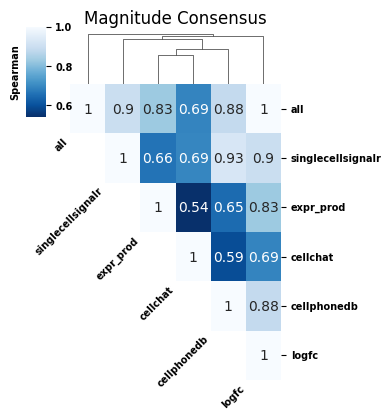

In [15]:
cm = c2c.plotting.clustermap_cci(magnitude_corr,
                                 method='ward',
                                 optimal_leaf=True,
                                 metadata=None,
                                 title='',
                                 cbar_title='Spearman', 
                                 cmap='Blues_r',
                                 vmax=1.,
#                                  vmin=0.,
                                 annot=True, 
                                 dendrogram_ratio=0.15,
                                figsize=(4,5))

font = matplotlib.font_manager.FontProperties(weight='bold', size=7)
for ax in [cm.ax_heatmap, cm.ax_cbar]:
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(font)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(font)

    text = ax.yaxis.label
    text.set_font_properties(font)
cm.ax_col_dendrogram.set_title('Magnitude Consensus')
;

We are particularly interested in differences with all scores (top row). We can see that, for the magnitude, CellChat has the largest effect on the consensus score. This is line with results from Tutorial 02 indicated that the CellChat score was the most dissimilar (see the `liana_corr`variable from that notebook). Let's see what this looks like for the specificity consensus scores as well:

Interaction space detected as a distance matrix


''

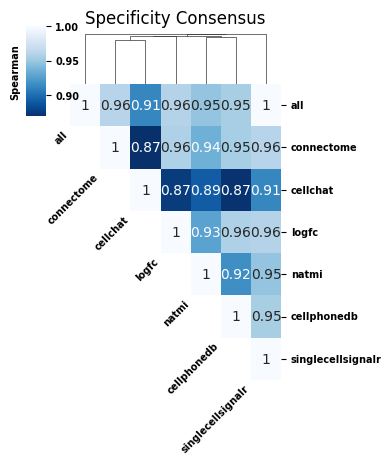

In [16]:
cm = c2c.plotting.clustermap_cci(specificity_corr,
                                 method='ward',
                                 optimal_leaf=True,
                                 metadata=None,
                                 title='',
                                 cbar_title='Spearman', 
                                 cmap='Blues_r',
                                 vmax=1.,
#                                  vmin=0.,
                                 annot=True, 
                                 dendrogram_ratio=0.15,
                                figsize=(4,5))

font = matplotlib.font_manager.FontProperties(weight='bold', size=7)
for ax in [cm.ax_heatmap, cm.ax_cbar]:
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(font)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(font)

    text = ax.yaxis.label
    text.set_font_properties(font)
cm.ax_col_dendrogram.set_title('Specificity Consensus')
;

Specificity consensus scores are even less sensitive to individual scoring methods than magnitude consensus scores. While the consensus score leaving CellChat out still has the lowest consistency as compared to including all scoring methods, it still has a large Spearman correlation (0.91). Overall, these results indicate that aggregating across scoring methods yields robust results that are not sensitive to any individual method.  

Given the high overall similarity between score types, we see that Tensor-cell2cell's decomposition tends to capture consistent patterns across samples, smoothing over some of the inconsistencies in communication scores that we saw at the individual sample level in [Tutorial 02](./02-Infer-Communication-Scores.ipynb) 